In [1]:
import tensorflow_datasets as tfds
import numpy as np

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np


### load imdb review dataset with tf datasets

In [2]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

In [3]:
encoder = info.features['text'].encoder

print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [4]:
info #info.splits['train'].num_examples

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=0.1.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    urls=['http://ai.stanford.edu/~amaas/data/sentiment/'],
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts

### explore the data

In [5]:
for train_example, train_label in train_data.take(1): #create a dataset of one sample
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  12   31   84  480   71    1  108 7748    9 1130]
Label: 1


In [6]:
encoder.decode(train_example)

'I have no idea what the other reviewer is talking about- this was a wonderful movie, and created a sense of the era that feels like time travel. The characters are truly young, Mary is a strong match for Byron, Claire is juvenile and a tad annoying, Polidori is a convincing beaten-down sycophant... all are beautiful, curious, and decadent... not the frightening wrecks they are in Gothic.<br /><br />Gothic works as an independent piece of shock film, and I loved it for different reasons, but this works like a Merchant and Ivory film, and was from my readings the best capture of what the summer must have felt like. Romantic, yes, but completely rekindles my interest in the lives of Shelley and Byron every time I think about the film. One of my all-time favorites.'

In [7]:

for (x,y) in tfds.as_numpy(train_data.take(2)): #transform to numpy 
    print(x.shape, y)

(248,) 1
(177,) 1


### Vectorize with One Hot Encoding 
There are 8185 words in the vocabulary. Apply OneHotEncoding - so there are 8185 features, if a word i is present in the example, then of the feature i put a 1, otherwise put a 0

In [8]:
#vectorize x
def vectorize_sequences(number_of_examples, dimension, data):
    results = np.zeros((number_of_examples, dimension ))
    labels = np.zeros((number_of_examples))
    for i, (x,y) in enumerate(tfds.as_numpy(data)): 
        results[i, x] = 1.  # set specific indices of results[i] to 1s
        labels[i]=int(y)
    return (results, labels)
#vectorize train data
(x_train, y_train) = vectorize_sequences(info.splits['train'].num_examples, encoder.vocab_size, train_data)
(x_test, y_test) = vectorize_sequences(info.splits['test'].num_examples, encoder.vocab_size, test_data)

print(y_train.shape)
#see the values
for i,i1 in zip(x_train[0:1], x_test[0:1]):
    for j,j1 in zip(i[0:3],i1[0:3]):
        print(j, j1)


(25000,)
0.0 0.0
1.0 1.0
1.0 1.0


In [9]:
#example from numpy for setting a list of elements to a certain value
a=np.array([2,1,3,4,0, 10])
a[[2,4,5]]=1
a


array([2, 1, 1, 4, 1, 1])

### set up the experiment
create a folder for logs for tensorboard

In [10]:
import pathlib
import os
logdir = pathlib.Path("../tensorboard_logs/overfit_and_underfit")
if not logdir.exists():
    os.makedirs(logdir)
name='default'

### create the architecture, compile the model and train it
During training, monitor the loss and acuracy not only on train, but also on test set

In [11]:
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='default'
history= model.fit(x_train, y_train, epochs=15, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 3s 117us/sample - loss: 0.5057 - accuracy: 0.7870 - val_loss: 0.3590 - val_accuracy: 0.8664
Epoch 2/15
25000/25000 [==============================] - 2s 86us/sample - loss: 0.2692 - accuracy: 0.9044 - val_loss: 0.2993 - val_accuracy: 0.8807
Epoch 3/15
25000/25000 [==============================] - 2s 78us/sample - loss: 0.2000 - accuracy: 0.9282 - val_loss: 0.3136 - val_accuracy: 0.8759
Epoch 4/15
25000/25000 [==============================] - 2s 89us/sample - loss: 0.1622 - accuracy: 0.9420 - val_loss: 0.3277 - val_accuracy: 0.8728
Epoch 5/15
25000/25000 [==============================] - 2s 95us/sample - loss: 0.1335 - accuracy: 0.9538 - val_loss: 0.3558 - val_accuracy: 0.8674
Epoch 6/15
25000/25000 [==============================] - 2s 87us/sample - loss: 0.1086 - accuracy: 0.9656 - val_loss: 0.3936 - val_accuracy: 0.8620
Epoch 7/15
25000/25000 [==============================]

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  130976    
_________________________________________________________________
dense_1 (Dense)              multiple                  272       
_________________________________________________________________
dense_2 (Dense)              multiple                  17        
Total params: 131,265
Trainable params: 131,265
Non-trainable params: 0
_________________________________________________________________


In [13]:
#one way to look at history values
import pandas as pd
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
10,0.022322,0.99780,0.598922,0.85020,10
11,0.015221,0.99896,0.637126,0.85152,11
12,0.010225,0.99932,0.684528,0.85000,12
13,0.006804,0.99964,0.733066,0.84996,13
14,0.004640,0.99980,0.774771,0.84972,14


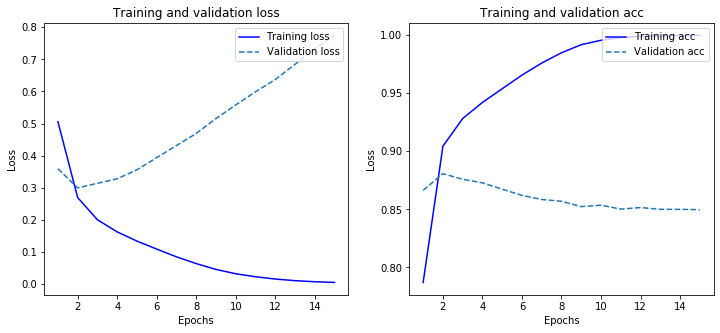

In [18]:

import matplotlib.pyplot as plt
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)
    #axs[0].bar(names, values)
    #axs[1].scatter(names, values)
    #axs[2].plot(names, values)

    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    axs[0].plot(epochs, loss, 'b', label='Training loss')
    axs[0].plot(epochs, val_loss, '--', label='Validation loss')
    axs[0].set_title('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc="upper right")

    axs[1].plot(epochs, acc, 'b', label='Training acc')
    axs[1].plot(epochs, val_acc, '--', label='Validation acc')
    axs[1].set_title('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc="upper right")

def plot_compared_val_loss(history1, history2, name1, name2):
    
    loss1 = history1.history['val_loss']
    loss2 = history2.history['val_loss']
    
    epochs = range(1, len(loss1) + 1)

    plt.plot(epochs, loss1, 'b', label=name1)
    plt.plot(epochs, loss2, '--', label=name2)
    plt.title('Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_history(history)


In [15]:
#smaller
model = keras.Sequential([
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='smaller'
smaller_history= model.fit(x_train, y_train, epochs=15, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 3s 104us/sample - loss: 0.6346 - accuracy: 0.6944 - val_loss: 0.5523 - val_accuracy: 0.8179
Epoch 2/15
25000/25000 [==============================] - 2s 71us/sample - loss: 0.4522 - accuracy: 0.8653 - val_loss: 0.4081 - val_accuracy: 0.8608
Epoch 3/15
25000/25000 [==============================] - 2s 67us/sample - loss: 0.3297 - accuracy: 0.8981 - val_loss: 0.3405 - val_accuracy: 0.8757
Epoch 4/15
25000/25000 [==============================] - 2s 75us/sample - loss: 0.2659 - accuracy: 0.9140 - val_loss: 0.3112 - val_accuracy: 0.8800
Epoch 5/15
25000/25000 [==============================] - 2s 74us/sample - loss: 0.2272 - accuracy: 0.9246 - val_loss: 0.2993 - val_accuracy: 0.8809
Epoch 6/15
25000/25000 [==============================] - 2s 71us/sample - loss: 0.2001 - accuracy: 0.9330 - val_loss: 0.2965 - val_accuracy: 0.8807
Epoch 7/15
25000/25000 [==============================]

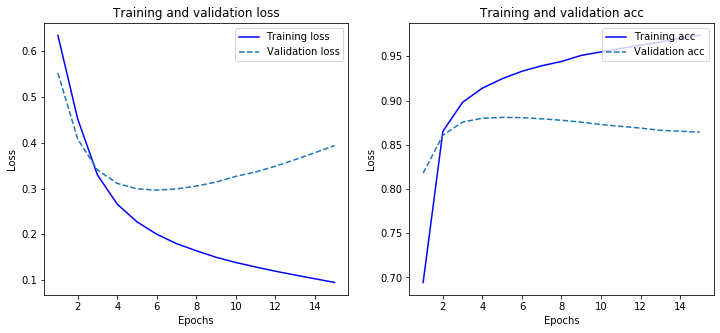

In [16]:
plot_history(smaller_history)

Francois Chollet: "Unfortunately, there is no magical formula to determine the right number of layers or the right size for each layer. You must evaluate an array of differenht architectures (on your validations set) in order o din an appropriate model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and parameteres , and increase the size of teh laters or add new layers until you see diminisihing returns with regard to validation loss. "
In this case, smaller network start overfitting later than the reference network and its performance degrades more slowly once it start overfitting

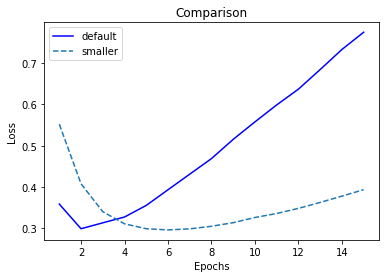

In [19]:
plot_compared_val_loss(history, smaller_history, 'default', 'smaller')

In [20]:
#huge
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='huge'
huge_history= model.fit(x_train, y_train, epochs=15, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 15s 593us/sample - loss: 0.4094 - accuracy: 0.8128 - val_loss: 0.3194 - val_accuracy: 0.8648
Epoch 2/15
25000/25000 [==============================] - 15s 592us/sample - loss: 0.1638 - accuracy: 0.9390 - val_loss: 0.3226 - val_accuracy: 0.8712
Epoch 3/15
25000/25000 [==============================] - 14s 576us/sample - loss: 0.0468 - accuracy: 0.9869 - val_loss: 0.4429 - val_accuracy: 0.8637
Epoch 4/15
25000/25000 [==============================] - 14s 573us/sample - loss: 0.0060 - accuracy: 0.9991 - val_loss: 0.5778 - val_accuracy: 0.8668
Epoch 5/15
25000/25000 [==============================] - 14s 573us/sample - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.6643 - val_accuracy: 0.8658
Epoch 6/15
25000/25000 [==============================] - 15s 586us/sample - loss: 2.7213e-04 - accuracy: 1.0000 - val_loss: 0.7142 - val_accuracy: 0.8658
Epoch 7/15
25000/25000 [================

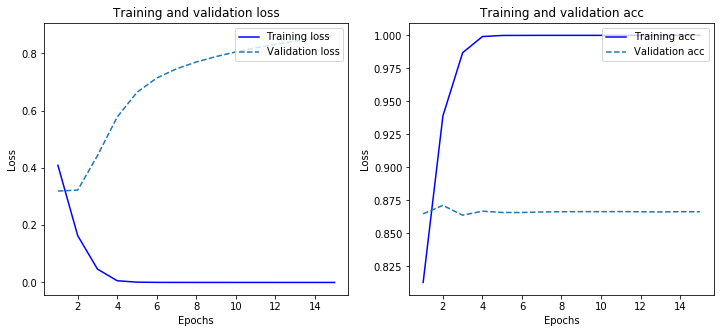

In [21]:
plot_history(huge_history)

The bigger network starts overfitting almost immediately

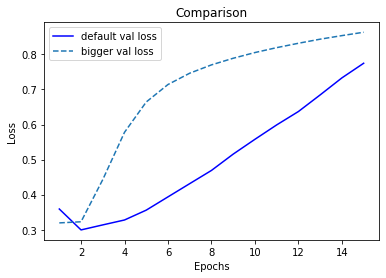

In [22]:
plot_compared_val_loss(history, huge_history, 'default val loss', 'bigger val loss')

In [23]:
### Regularization

In [24]:
#regularization
#l2(0.001 ) every coef in weight matrix will add 0.001*weight_coef_value to the total loss of the network
#square of the value of the weight coeffs
#l1 - absolute value of the weight coeffs
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='regularization'
reg_history= model.fit(x_train, y_train, epochs=15, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 3s 123us/sample - loss: 0.5394 - accuracy: 0.7993 - val_loss: 0.3959 - val_accuracy: 0.8669
Epoch 2/15
25000/25000 [==============================] - 2s 89us/sample - loss: 0.3171 - accuracy: 0.9045 - val_loss: 0.3570 - val_accuracy: 0.8792
Epoch 3/15
25000/25000 [==============================] - 2s 84us/sample - loss: 0.2615 - accuracy: 0.9276 - val_loss: 0.3607 - val_accuracy: 0.8790
Epoch 4/15
25000/25000 [==============================] - 2s 89us/sample - loss: 0.2341 - accuracy: 0.9384 - val_loss: 0.3774 - val_accuracy: 0.8753
Epoch 5/15
25000/25000 [==============================] - 2s 90us/sample - loss: 0.2174 - accuracy: 0.9460 - val_loss: 0.4019 - val_accuracy: 0.8695
Epoch 6/15
25000/25000 [==============================] - 2s 97us/sample - loss: 0.2047 - accuracy: 0.9512 - val_loss: 0.4213 - val_accuracy: 0.8646
Epoch 7/15
25000/25000 [==============================]

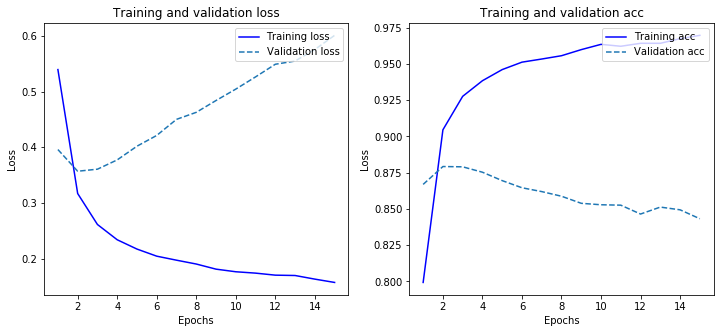

In [25]:
plot_history(reg_history)

The penaly of L2 is only added at training time, the loss for this network will be higher at the training than at the test time. Yje model become more resistant to overfitting even though they both have the same number of parameters.

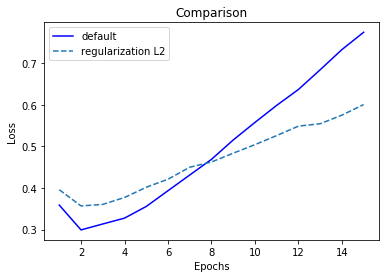

In [35]:
#reg_history.history['loss'],
plot_compared_val_loss(history, reg_history, 'default', 'regularization L2')

In [27]:
#dropout

model = keras.Sequential([
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='dropout'
dropout_history= model.fit(x_train, y_train, epochs=15, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 3s 124us/sample - loss: 0.6403 - accuracy: 0.6330 - val_loss: 0.5320 - val_accuracy: 0.8398
Epoch 2/15
25000/25000 [==============================] - 2s 85us/sample - loss: 0.4981 - accuracy: 0.7851 - val_loss: 0.3817 - val_accuracy: 0.8722
Epoch 3/15
25000/25000 [==============================] - 2s 90us/sample - loss: 0.3904 - accuracy: 0.8502 - val_loss: 0.3176 - val_accuracy: 0.8791
Epoch 4/15
25000/25000 [==============================] - 2s 85us/sample - loss: 0.3252 - accuracy: 0.8822 - val_loss: 0.2949 - val_accuracy: 0.8804
Epoch 5/15
25000/25000 [==============================] - 2s 88us/sample - loss: 0.2792 - accuracy: 0.8989 - val_loss: 0.2908 - val_accuracy: 0.8791
Epoch 6/15
25000/25000 [==============================] - 2s 95us/sample - loss: 0.2447 - accuracy: 0.9140 - val_loss: 0.2973 - val_accuracy: 0.8807
Epoch 7/15
25000/25000 [==============================]

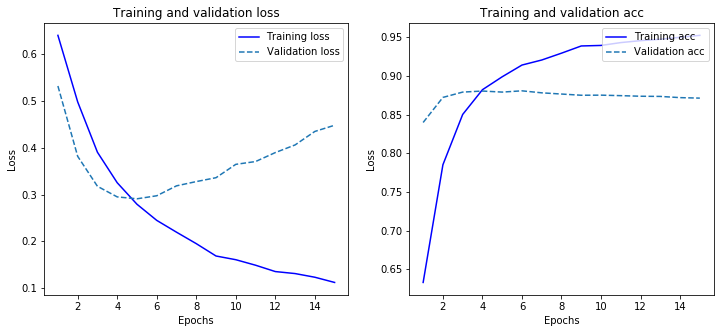

In [28]:
plot_history(dropout_history)

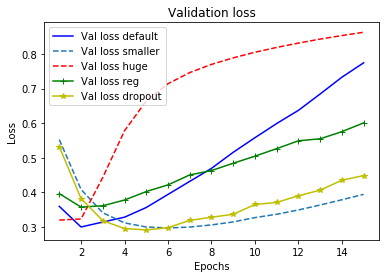

In [34]:
loss_default = history.history['val_loss']
loss_small = smaller_history.history['val_loss']
loss_huge = huge_history.history['val_loss']

loss_reg = reg_history.history['val_loss']
loss_drop = dropout_history.history['val_loss']
epochs = range(1, len(loss_default) + 1)

plt.plot(epochs, loss_default, 'b', label='Val loss default')
plt.plot(epochs, loss_small, '--', label='Val loss smaller')
plt.plot(epochs, loss_huge, 'r--', label='Val loss huge')
plt.plot(epochs, loss_reg, 'g-+', label='Val loss reg')
plt.plot(epochs, loss_drop, 'y-*', label='Val loss dropout')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()